In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [54]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    try:
        warnings.simplefilter("error")
        if not check_feasibility(L, a, b):
            raise ValueError("infeasible")
        
        x = cp.Variable(len(a))

        if metric == "sw":
            objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        elif (metric == "pf") or (metric == 1):
            objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
        elif metric == "mm":
            objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        else:
            y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
            objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))

        constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver="ECOS", abstol=1e-6)

        user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
        surplus = np.sum(user_surplus)

        return problem.value, x.value, user_surplus, surplus, "success"
    
    except (Warning, cp.SolverError, TypeError, ValueError) as e:
        return np.nan, np.full(len(a), np.nan), np.full(len(a), np.nan), np.nan, str(e)


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]

    np.random.seed(seed)
    a = 1*np.random.rand(n_users) + 1
    b = (a + 1)*10 + 10*np.random.rand(n_users) + 1
        
    sw_val, sw_sol, sw_user_surplus, sw_surplus, sw_message = solve(L, a, b, "sw")
    pf_val, pf_sol, pf_user_surplus, pf_surplus, pf_message = solve(L, a, b, "pf")
    mm_val, mm_sol, mm_user_surplus, mm_surplus, mm_message = solve(L, a, b, "mm")
    alpha0_val, alpha0_sol, alpha0_user_surplus, alpha0_surplus, alpha0_message = solve(L, a, b, 0.5)
    alpha1_val, alpha1_sol, alpha1_user_surplus, alpha1_surplus, alpha1_message = solve(L, a, b, 1.5)
    #alpha2_val, alpha2_sol, alpha2_user_surplus, alpha2_surplus, alpha2_message = solve(L, a, b, 3.0)        
    messages = dict(sw=sw_message, pf=pf_message, mm=mm_message, alpha0=alpha0_message, alpha1=alpha1_message)
        
    return dict(
        experiment_id=f"{n_users}-{seed}", n_users=n_users, seed=seed, messages=messages, L=L,
        sw_val=sw_val, sw_sol=sw_sol, sw_surplus=sw_surplus, sw_min_surplus=np.min(sw_user_surplus),
        pf_val=pf_val, pf_sol=pf_sol, pf_surplus=pf_surplus, pf_min_surplus=np.min(pf_user_surplus),
        mm_val=mm_val, mm_sol=mm_sol, mm_surplus=mm_surplus, mm_min_surplus=np.min(mm_user_surplus),
        alpha0_val=alpha0_val, alpha0_sol=alpha0_sol, alpha0_surplus=alpha0_surplus, alpha0_min_surplus=np.min(alpha0_user_surplus),
        alpha1_val=alpha1_val, alpha1_sol=alpha1_sol, alpha1_surplus=alpha1_surplus, alpha1_min_surplus=np.min(alpha1_user_surplus),
        #alpha2_val=alpha2_val, alpha2_sol=alpha2_sol, alpha2_surplus=alpha2_surplus, alpha2_min_surplus=np.min(alpha2_user_surplus),        
    )

In [55]:
%%time
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in np.arange(0.1, 100, 0.1)
    for n_users in [10, 100, 1000]
    for seed in range(100)
]

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
results = pd.DataFrame(results)
pool.close()

CPU times: user 24.9 s, sys: 9.62 s, total: 34.6 s
Wall time: 5min 53s


In [76]:

select_cols = ["n_users", "sw_surplus", "pf_surplus", "mm_surplus", "alpha0_surplus", "alpha1_surplus"]
select_cols += ["sw_min_surplus", "pf_min_surplus", "mm_min_surplus", "alpha0_min_surplus", "alpha1_min_surplus"]
df = results.dropna().groupby("experiment_id")[select_cols].max().reset_index()

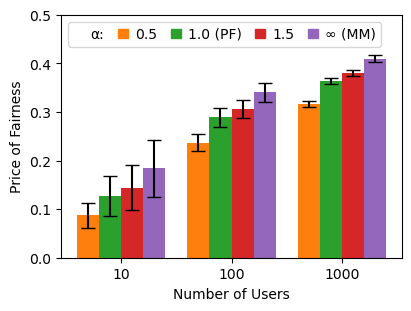

In [200]:
# calculate price of fairness
df["1.0 (PF)"] = (df.sw_surplus - df.pf_surplus) / df.sw_surplus
df["∞ (MM)"] = (df.sw_surplus - df.mm_surplus) / df.sw_surplus
df["0.5"] = (df.sw_surplus - df.alpha0_surplus) / df.sw_surplus
df["1.5"] = (df.sw_surplus - df.alpha1_surplus) / df.sw_surplus

df_errors = df.groupby("n_users")[["0.5", "1.0 (PF)",  "1.5", "∞ (MM)"]].std().to_dict()
df_errors = {k:list(v.values())  for k,v in df_errors.items()}

df_means = df.groupby("n_users")[["0.5", "1.0 (PF)",  "1.5", "∞ (MM)"]].mean().to_dict()
df_means = {k:list(v.values())  for k,v in df_means.items()}

n_users = (10, 100, 1000)
x = np.arange(len(n_users))
width = 0.2

fig, ax = plt.subplots(layout="constrained", figsize=(4, 3))

for i, (attribute, measurement) in enumerate(df_means.items()):
    offset = width * i
    error = df_errors[attribute]
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=error, capsize=5, color=f"C{i+1}") 

ax.set_ylabel("Price of Fairness")
ax.set_xticks(x + 1.5*width, n_users)

legend_labels = ["α:"] + list(df_means.keys()) 
legend_handles = [mpatches.Patch(color="w" if i == 0 else f"C{i}", label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, loc="upper left", ncol=5, columnspacing=1, handlelength=0.7, handletextpad=0.5)

ax.set_ylim(0, 0.5)
ax.set_xlabel("Number of Users")
plt.show()

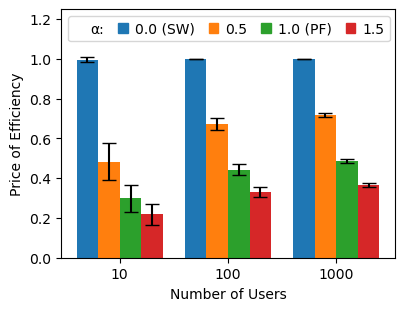

In [201]:
# calculate price of efficiency
df["0.0 (SW)"] = (df.mm_min_surplus - df.sw_min_surplus) / df.mm_min_surplus
df["1.0 (PF)"] = (df.mm_min_surplus - df.pf_min_surplus) / df.mm_min_surplus
df["0.5"] = (df.mm_min_surplus - df.alpha0_min_surplus) / df.mm_min_surplus
df["1.5"] = (df.mm_min_surplus - df.alpha1_min_surplus) / df.mm_min_surplus



df_errors = df.groupby("n_users")[["0.0 (SW)", "0.5", "1.0 (PF)",  "1.5"]].std().to_dict()
df_errors = {k:list(v.values())  for k,v in df_errors.items()}

df_means = df.groupby("n_users")[["0.0 (SW)", "0.5", "1.0 (PF)",  "1.5"]].mean().to_dict()
df_means = {k:list(v.values())  for k,v in df_means.items()}

n_users = (10, 100, 1000)
x = np.arange(len(n_users)) 
width = 0.2


fig, ax = plt.subplots(layout="constrained", figsize=(4, 3))

for i, (attribute, measurement) in enumerate(df_means.items()):
    offset = width * i
    error = df_errors[attribute]
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=error, capsize=5)    

ax.set_ylabel("Price of Efficiency")
ax.set_xticks(x + 1.5*width, n_users)

legend_labels = ["α:"] + list(df_means.keys())
legend_handles = [mpatches.Patch(color="w" if i == 0 else f"C{i-1}", label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, loc="upper left", ncol=5, columnspacing=1, handlelength=0.7, handletextpad=0.5)

ax.set_ylim(0, 1.25)
ax.set_xlabel("Number of Users")
plt.show()
